In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from dedalus import public as de
from dedalus.extras import flow_tools
import time
from IPython import display

In [3]:
import logging
root = logging.root
for h in root.handlers:
    h.setLevel("INFO")
    
logger = logging.getLogger(__name__)

In [4]:
Lx, Ly = (0.5, 0.4)
nx, ny = (256, 256)

x_basis = de.Fourier('x', nx, interval=(0, Lx), dealias=3/2)
y_basis = de.Chebyshev('y', ny, interval=(0, Ly), dealias=3/2)
domain = de.Domain([x_basis, y_basis], grid_dtype=np.float64)

In [5]:
problem = de.IVP(domain, variables=['p', 'u', 'v', 'ρ', 'uy', 'vy', 'ρy'])

In [6]:
ρ_lower = 998.23 #Tap_water
A = 7e-4 #Atwood number
ρ_upper = (ρ_lower * (1 + A))/(1 - A) #

In [7]:
ρ0 = (ρ_upper + ρ_lower)/2

In [8]:
problem.parameters['Re'] = 1e8
problem.parameters['ρ0'] = ρ_lower
problem.parameters['g'] = 9.8

problem.add_equation("dt(u) + dx(p) - 1/Re*(dx(dx(u)) + dy(uy)) = - u*dx(u) - v*uy")
problem.add_equation("dt(v) + dy(p) - 1/Re*(dx(dx(v)) + dy(vy)) = - u*dx(v) - v*vy - g*(ρ - ρ0)/ρ0")
problem.add_equation("dx(u) + vy = 0")
problem.add_equation("dt(ρ) = - u*dx(ρ) - v*ρy")
problem.add_equation("uy - dy(u) = 0")
problem.add_equation("vy - dy(v) = 0")
problem.add_equation("ρy - dy(ρ) = 0")


In [9]:
problem.add_bc("left(u) = 0")
problem.add_bc("right(u) = 0")
problem.add_bc("left(v) = 0")
problem.add_bc("right(v) = 0", condition="(nx != 0)")
problem.add_bc("right(p) = 0", condition="(nx == 0)")
problem.add_bc("left(ρ) = ρ0")

In [30]:
ρ_lower < ρ_upper

True

In [10]:
ts = de.timesteppers.RK

In [11]:
solver =  problem.build_solver(ts)

2017-08-04 13:07:32,145 pencil 0/1 INFO :: Building pencil matrix 1/128 (~1%) Elapsed: 0s, Remaining: 6s, Rate: 2.0e+01/s
2017-08-04 13:07:32,496 pencil 0/1 INFO :: Building pencil matrix 13/128 (~10%) Elapsed: 0s, Remaining: 4s, Rate: 3.3e+01/s
2017-08-04 13:07:33,079 pencil 0/1 INFO :: Building pencil matrix 26/128 (~20%) Elapsed: 1s, Remaining: 4s, Rate: 2.6e+01/s
2017-08-04 13:07:33,457 pencil 0/1 INFO :: Building pencil matrix 39/128 (~30%) Elapsed: 1s, Remaining: 3s, Rate: 2.9e+01/s
2017-08-04 13:07:33,831 pencil 0/1 INFO :: Building pencil matrix 52/128 (~41%) Elapsed: 2s, Remaining: 3s, Rate: 3.0e+01/s
2017-08-04 13:07:34,296 pencil 0/1 INFO :: Building pencil matrix 65/128 (~51%) Elapsed: 2s, Remaining: 2s, Rate: 3.0e+01/s
2017-08-04 13:07:34,678 pencil 0/1 INFO :: Building pencil matrix 78/128 (~61%) Elapsed: 3s, Remaining: 2s, Rate: 3.0e+01/s
2017-08-04 13:07:35,052 pencil 0/1 INFO :: Building pencil matrix 91/128 (~71%) Elapsed: 3s, Remaining: 1s, Rate: 3.1e+01/s
2017-08-04

In [12]:
x = domain.grid(0)
y = domain.grid(1)
ρ = solver.state['ρ']
yb, yt = y_basis.interval

In [13]:
y.shape

(1, 256)

In [14]:
xm, ym = np.meshgrid(x,y)

In [15]:
xm.shape

(256, 256)

In [16]:
ρ['g'] = np.zeros_like(ρ['g'])

In [17]:
 ρ['g'].shape

(256, 256)

In [21]:
for i in range(0, 64):
    ρ['g'][:, i] = ρ['g'][:, i] + ρ_lower
    
for i in range(64, 128):
     ρ['g'][:, i] = ρ['g'][:, i] + ρ_upper

In [19]:
ρ['g'][64, 64] = ρ_lower

In [21]:
#for j in range(0, nx, 5):
 #   ρ['g'][j, 64] = ρ_lower

In [22]:
ρ['g'].shape

(128, 128)

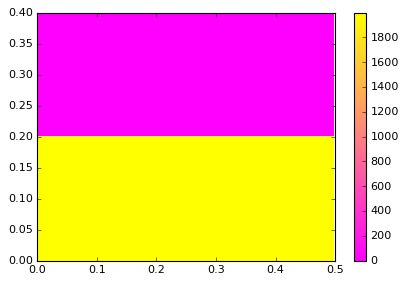

In [22]:
plt.pcolormesh(xm, ym, ρ['g'].T, cmap='spring')
plt.colorbar()

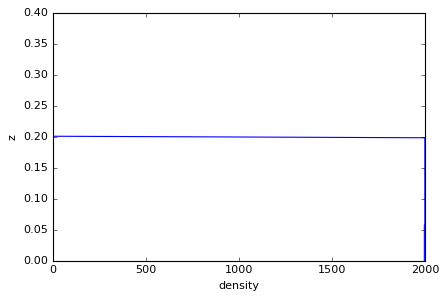

In [23]:
plt.plot(ρ['g'][1], y[0])
plt.xlabel('density')
plt.ylabel('z')

In [25]:
0.2*Lx/nx

0.000390625

In [26]:
# Initial timestep
dt = 0.2*Lx/nx
# Integration parameters
solver.stop_sim_time = .2
solver.stop_wall_time = np.inf
solver.stop_iteration = np.inf

# Analysis
snapshots = solver.evaluator.add_file_handler('RT_1', sim_dt=0.01, max_writes=50)
snapshots.add_system(solver.state)

# CFL
CFL = flow_tools.CFL(solver, dt,safety=0.8)
CFL.add_velocities(('u', 'v'))

#flow = flow_tools.GlobalFlowProperty(solver, cadence=10)
#flow.add_property("sqrt(u*u + v*v) / R", name='Re')

In [27]:
logger.info('Starting loop')
start_time = time.time()
while solver.ok:
    dt = CFL.compute_dt()
    dt = solver.step(dt)
    if (solver.iteration-1) % 10 == 0:
        logger.info('Iteration: %i, Time: %e, dt: %e' %(solver.iteration, solver.sim_time, dt))

end_time = time.time()
logger.info('Iterations: %i' %solver.iteration)
logger.info('Sim end time: %f' %solver.sim_time)
logger.info('Run time: %.2f sec' %(end_time-start_time))
logger.info('Run time: %f cpu-hr' %((end_time-start_time)/60/60*domain.dist.comm_cart.size))


2017-08-04 13:08:20,521 __main__ 0/1 INFO :: Starting loop
2017-08-04 13:08:22,373 __main__ 0/1 INFO :: Iteration: 1, Time: 3.906250e-04, dt: 3.906250e-04


ValueError: Invalid timestep

In [36]:
np.isfinite

True

In [ ]:
def extraer_datos(nombre_h5):

    with h5py.File(nombre_h5, flag ='r') as hdf:
        base_items = list(hdf.items())
        print(base_items, '\n')
        tasks = hdf.get('tasks')
        tasks_items = list(tasks.items())
        print(tasks_items)

        ρ = np.array(tasks.get('ρ'))
        print(ρ.shape)
        
    return  ρ

In [ ]:
ρ_dat = extraer_datos('RT_1/RT_1_s1/RT_1_s1_p0.h5')

In [ ]:
ρ_dat.shape

In [ ]:
fig, axis = plt.subplots(figsize=(6,4.8))
p = axis.pcolormesh(xm, ym, ρ_dat[-1].T, cmap='summer');
plt.colorbar(p)